Deep Learning
=============


# Assignment 2


Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

这个作业的目标是使用TensorFlow逐步训练更深入，更准确的模型

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

## 下载数据

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


## 数据预处理

将数据重新格式化为更适合我们要训练的模型的形状：
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


## 简单的梯度下降

We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

将所有数据加载到TensorFlow中，并构建与我们的训练相对应的计算图：

In [9]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()

with graph.as_default():

  # 1.Input data.
  # Load the training, validation and test data into constants that are attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # 2.Variables.
  # 这些是我们将要训练的参数。
  # 使用（截断的）正态分布的随机值来初始化权重矩阵。
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))

  # 偏差初始化为零。
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # 3.Training computation.
  # We multiply the inputs with the weight matrix, and add biases. 
  logits = tf.matmul(tf_train_dataset, weights) + biases
  
  # 计算softmax and 交叉熵(cross-entropy) (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). 
  # 在所有训练样例中采用这种交叉熵的平均值：作为我们的损失函数
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # 4.Optimizer.
  # 使用梯度下降找到损失函数的最小值。
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # 5.Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

- `logits = tf.matmul(weights, tf_train_dataset) + biases` 等价于逻辑回归公式 $Y' = WX + b$
- Transpose y_hat and y to fit in `softmax_cross_entropy_with_logits`

迭代运算


- Use `np.argmax(predictions, axis=0)` to transfrom one-hot encoded labels back to singe number for every data points.
- Use `.eval()` to get the predictions for test/validation set


In [10]:
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the biases. 
    
  tf.global_variables_initializer().run()
  print('Initialized')
    
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
        
        print('Cost at step {}: {:.3f}. Training acc: {:.1f}%, Validation acc: {:.1f}%.'.format(
            step, l,
            accuracy(predictions, train_labels[:, :train_subset]),
            accuracy(valid_prediction.eval(), valid_labels), ">"))
      # Calling .eval() on valid_prediction is basically like calling run(), but just to get that one numpy array. 
      # Note that it recomputes all its graph dependencies.
    
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized


/home/bai/anaconda3/envs/gymlab/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """


Cost at step 0: 15.598. Training acc: 0.0%, Validation acc: 15.9%.
Cost at step 100: 2.359. Training acc: 0.0%, Validation acc: 71.0%.
Cost at step 200: 1.886. Training acc: 0.0%, Validation acc: 73.2%.
Cost at step 300: 1.629. Training acc: 0.0%, Validation acc: 73.8%.
Cost at step 400: 1.457. Training acc: 0.0%, Validation acc: 74.0%.
Cost at step 500: 1.331. Training acc: 0.0%, Validation acc: 74.5%.
Cost at step 600: 1.233. Training acc: 0.0%, Validation acc: 74.6%.
Cost at step 700: 1.155. Training acc: 0.0%, Validation acc: 74.8%.
Cost at step 800: 1.091. Training acc: 0.0%, Validation acc: 75.0%.
Test accuracy: 82.5%


## 随机梯度下降

Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

图形是类似的，不同的地方在于不是将所有训练数据保存到一个常量节点中，而是创建一个“占位符”节点，它将在每次调用`session.run（）`时提供实际数据。

SGD和梯度下降之间的区别在于前者不使用整个训练集来计算梯度下降，而只是使用它的“小批量”并假设相应的梯度下降是优化的方式。 因此，

- 可以继续使用GradientDescentOptimize，但是从较小的子训练集计算出不同的损失。

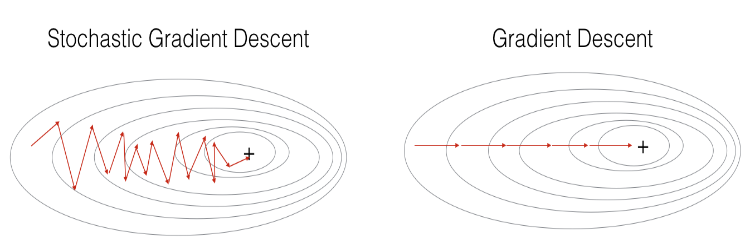

In [11]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # 1.Input data. 
  # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size)) #(128,784)
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) #(128,10)
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # 2.Variables.
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels])) # (784,10)
  biases = tf.Variable(tf.zeros([num_labels])) #(10, )
  
  # 3.Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # 4.Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # 5.Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [12]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    
  tf.global_variables_initializer().run()
  print("Initialized")
    
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0):
        print('Minibatch loss at step {}: {:.3f}. Minibatch acc: {:.1f}%, Valid acc: {:.1f}%.'\
                  .format(step, l,
                          accuracy(predictions, batch_labels),
                          accuracy(valid_prediction.eval(), valid_labels)))
      
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 14.827. Minibatch acc: 6.2%, Valid acc: 13.6%.
Minibatch loss at step 500: 2.121. Minibatch acc: 75.8%, Valid acc: 75.7%.
Minibatch loss at step 1000: 1.189. Minibatch acc: 82.8%, Valid acc: 77.3%.
Minibatch loss at step 1500: 1.410. Minibatch acc: 78.1%, Valid acc: 77.1%.
Minibatch loss at step 2000: 1.271. Minibatch acc: 77.3%, Valid acc: 77.9%.
Minibatch loss at step 2500: 0.916. Minibatch acc: 82.8%, Valid acc: 78.2%.
Minibatch loss at step 3000: 0.787. Minibatch acc: 81.2%, Valid acc: 78.6%.
Test accuracy: 86.0%


SGD的关键是采用随机样本/小批量，并在每次迭代时将其提供给模型（`feed_dict`）。

---
Problem：NN
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

- A 2-layer NN (1-hidden layer NN) look like this: 

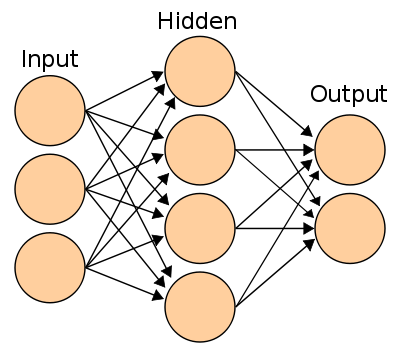


-  A ReLU activation unit look like this:

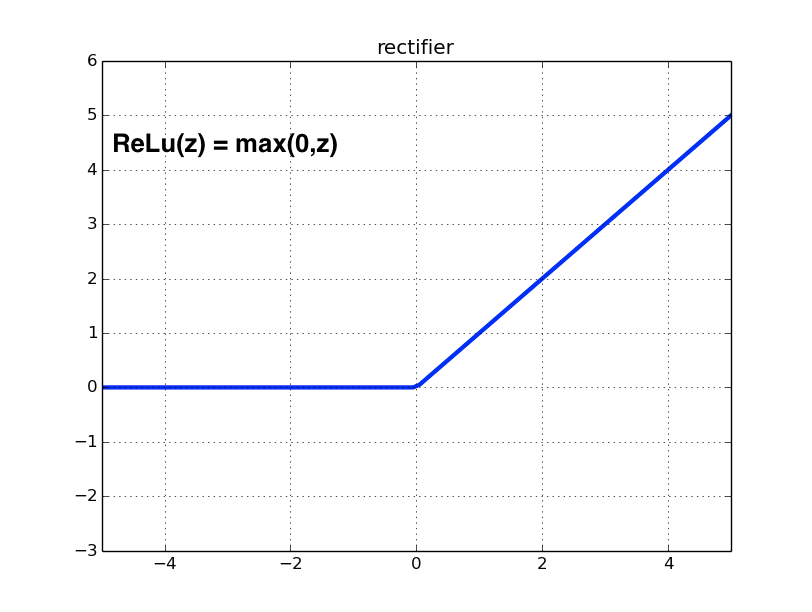

输出层的激活输出是：

$logits = W2 * ReLU(W1 * X + b1) + b2$

In [19]:
batch_size = 128
hidden_nodes = 1024

graph = tf.Graph()

with graph.as_default():

  # 1.Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size)) #(128,784)
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) #(128,10)
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # 2.Variables.
  # 隐藏层权重和偏差
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes])) # (784,1024)
  biases_1 = tf.Variable(tf.zeros([hidden_nodes])) # (1024, )
  # 输出层权重和偏差
  weights_2 = tf.Variable(
    tf.truncated_normal([hidden_nodes, num_labels])) # (1024,10)
  biases_2 = tf.Variable(tf.zeros([num_labels])) # (10，)
  
  # 3.Training computation.
  def forward_prop(input):
    h1 = tf.nn.relu(tf.matmul(input, weights_1) + biases_1)
    return tf.matmul(h1, weights_2) + biases_2
  
  logits = forward_prop(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
  
  # 4.Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # 5.Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
  test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

In [21]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
        print('Minibatch loss at step {}: {:.3f}. batch acc: {:.1f}%, Valid acc: {:.1f}%.'\
                  .format(step, l,
                          accuracy(predictions, batch_labels),
                          accuracy(valid_prediction.eval(), valid_labels)))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 367.541. batch acc: 9.4%, Valid acc: 34.2%.
Minibatch loss at step 500: 22.371. batch acc: 81.2%, Valid acc: 79.5%.
Minibatch loss at step 1000: 7.542. batch acc: 85.9%, Valid acc: 80.5%.
Minibatch loss at step 1500: 4.623. batch acc: 82.8%, Valid acc: 81.2%.
Minibatch loss at step 2000: 5.886. batch acc: 82.0%, Valid acc: 82.0%.
Minibatch loss at step 2500: 5.044. batch acc: 82.8%, Valid acc: 82.9%.
Minibatch loss at step 3000: 3.402. batch acc: 85.2%, Valid acc: 82.1%.
Test accuracy: 89.1%
